In [1]:
# Run this for pre-processesed dataset file
! git clone https://github.com/kendreaditya/ECG_DATA.git

Cloning into 'ECG_DATA'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.


In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from scipy.io import loadmat
import torch
import matplotlib.pyplot as plt


if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Running on GPU -", device )
else:
  device = torch.device("cpu")
  print("Running on CPU -", device )

# to run on gpu .to(device)

REBUILD_DATA = True # processing data

Running on GPU - cuda:0


In [3]:
training_data = np.load("ECG_DATA/training_Data.npy", allow_pickle=True)
print(len(training_data))

1944


100%|██████████| 1944/1944 [01:13<00:00, 28.88it/s]


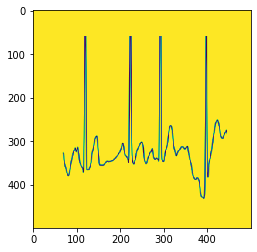

In [4]:
img_training_data = []

def ECG_Image():
  for data in tqdm(training_data):
    ecg = data[0]
    plt.figure(figsize=(5,5))
    plt.plot(ecg)
    plt.xlim(0, 1000)
    plt.ylim(-300, 700)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.savefig(fname="0", pad_inches=None)
    plt.close()
    path = "0.png"
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (500, 500))
    img_training_data.append([np.array(img), data[1]])

ECG_Image()
#print(img_training_data)
np.random.shuffle(img_training_data)
np.save("img_training_data.npy", img_training_data)
plt.imshow(img_training_data[0][0])
plt.show()

In [5]:
len(img_training_data[0][0][499])

500

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(500,500).view(-1,1,500,500)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 4) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=445568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)


In [8]:
img_training_data = np.load("img_training_data.npy", allow_pickle=True)
print(len(img_training_data))

1944


In [9]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss().to(device)

X = torch.Tensor([i[0] for i in img_training_data]).view(-1,500,500)
X /=225.0
y = torch.Tensor([i[1] for i in img_training_data])
 
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

194


In [10]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]
print(len(train_X), len(test_X))

1750 194


  1%|          | 2/175 [00:00<00:13, 12.92it/s]


Epoch: 0. Loss: 0.5


  1%|          | 2/175 [00:00<00:13, 12.88it/s]


Epoch: 1. Loss: 0.5


  1%|          | 2/175 [00:00<00:13, 12.92it/s]


Epoch: 2. Loss: 0.5


  1%|          | 2/175 [00:00<00:13, 12.89it/s]


Epoch: 3. Loss: 0.5


100%|██████████| 175/175 [00:21<00:00,  8.09it/s]



Epoch: 4. Loss: 0.5
[[0, 1, 2, 3, 4], [0.5, 0.5, 0.5, 0.5, 0.5]]


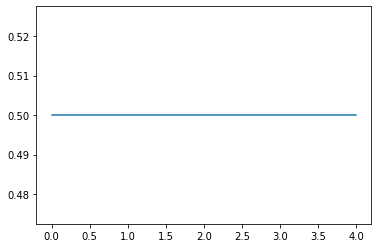

In [11]:
import matplotlib.pyplot as plt

BATCH_SIZE = 10
EPOCHS = 5
plot = []

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 500, 500).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update
    
    plot.append([epoch, float(loss)])
    print(f"\nEpoch: {epoch}. Loss: {loss}")
plot = list(map(list, zip(*plot)))
print(plot)
plt.plot(plot[0], plot[1])

In [13]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i]).to(device)
        net_out = net(test_X[i].view(-1, 1, 500, 500).to(device))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 194/194 [00:01<00:00, 154.63it/s]

Accuracy:  0.237
